In [1]:
import imutils
import cv2
import matplotlib.pyplot as plt

video_path = '../crabs_dataset/eval_videos/fullvideo_test6/sample6.mp4'
upper_bound = 50
lower_bound = 45
captured = False

# initialize the background subtractor
fgbg = cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames=5) 
# note that detect_scene not works for the frame in scene change whose index is smaller thant initializationFrames

vs = cv2.VideoCapture(video_path)
ret, frame = vs.read()

In [ ]:
vs.get(cv2.CAP_PROP_FPS)

In [ ]:
vs.get(cv2.CAP_PROP_FRAME_HEIGHT)

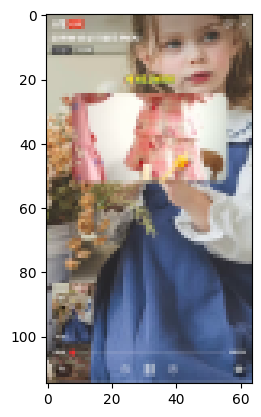

In [2]:
def showimg(frame):
    frame_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_img)
    plt.show()
frame = imutils.resize(frame, width=64, height=128)
showimg(frame)

In [3]:
mask = fgbg.apply(frame)
print(mask)
print(mask.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(115, 64)


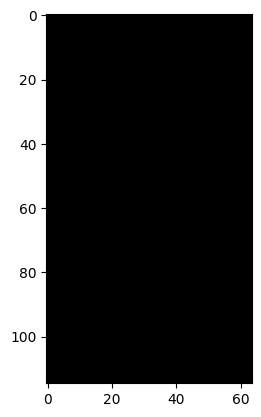

In [4]:
showimg(mask)

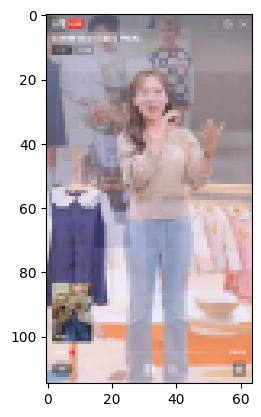

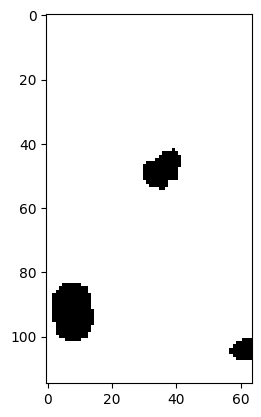

In [119]:
for i in range(3):
    ret, frame = vs.read()

frame = imutils.resize(frame, width=64, height=128)
showimg(frame)
mask = fgbg.apply(frame)
showimg(mask)


In [ ]:
mask = fgbg.apply(frame)
showimg(mask)
print(mask)
print(mask.shape)

In [ ]:
mask1 = cv2.erode(mask, None, iterations=2)
mask2 = cv2.dilate(mask1, None, iterations=2)

showimg(mask2)

In [ ]:
(W, H) = mask.shape[:2]

p = (cv2.countNonZero(mask)/float(W * H))
print(p)

In [ ]:
import torch
from video_pipeline import CrabsVideoPipeline
from resnet_simclr import ResNetSimCLR

video_path = '../crabs_dataset/eval_videos/fullvideo_test6/sample6.mp4'
panel_dir = '../crabs_dataset/eval_videos/fullvideo_test6/panels/'
model_path = './models/matching_model003.tar'
device = 'cuda'
pipeline = CrabsVideoPipeline(video_path, panel_dir, device)

arch = 'resnet18'
out_dim = 128
matching_model = ResNetSimCLR(arch, out_dim)
matching_model.load_state_dict(torch.load(model_path, map_location='cpu')['state_dict'])

pipeline.initialize_matching_model(matching_model)
pipeline.video_inference()

In [ ]:
output_path='./output/sample6_001.mp4'
pipeline.parse_output(output_path)

In [ ]:
print(pipeline.query_dir)
print(pipeline.intervals)

In [ ]:
interval_results = pipeline.video_inference()

In [ ]:
import numpy as np
print(interval_results.shape)
print(len(pipeline.intervals))

In [ ]:
pipeline.interval_results

In [ ]:
sorted_idx = np.flip(np.argsort(interval_results), axis=1)
sorted_idx.shape

In [ ]:
top3 = sorted_idx[:,:3]

In [ ]:
top3

In [ ]:
k=3
sorted_idx = np.flip(np.argsort(interval_results), axis=1)
topk = sorted_idx[:,:k]
for i in range(len(interval_results)):
    topk_score = interval_results[i][topk[i]]
    print(topk_score)

In [ ]:
interval_results[0][np.flip(sorted_idx)]

In [ ]:
np.flip(sorted_idx)

In [ ]:
import imutils
import cv2

video_path = '../crabs_dataset/eval_videos/fullvideo_test6/sample6.mp4'

def detect_scene(video_path):
    upper_bound = 0.6
    lower_bound = 0.45
    captured = False

    # initialize the background subtractor
    fgbg = cv2.bgsegm.createBackgroundSubtractorGMG(initializationFrames=3) 
    # note that detect_scene not works for the frame in scene change whose index is smaller thant initializationFrames

    vs = cv2.VideoCapture(video_path)
    (W, H) = (None, None)
    
    scene_bdy = []
    idx=0

    while(True):
        # ret: whether the frame is read correctly or not
        ret, frame = vs.read()
        if frame is None:
            break
        if idx%2==0:
            frame = imutils.resize(frame, width=64, height=128)
            mask = fgbg.apply(frame)

            # remove noise
            mask = cv2.erode(mask, None, iterations=2)
            mask = cv2.dilate(mask, None, iterations=2)

            if W is None or H is None:
                (W, H) = mask.shape[:2]

            # black: 0, white/changing part: 1
            p = (cv2.countNonZero(mask)/float(W * H))

            if p > upper_bound and not captured:
                captured = True
                scene_bdy.append(idx)
            elif captured and p < lower_bound:
                # return to capturing mode
                captured = False

        idx +=1
    # When everything done, release the capture
    scene_bdy.append(idx)
    scene_bdy.sort()
    scene_bdy = scene_bdy[1:]
    scene_bdy.append(0)
    scene_bdy.sort()

    return scene_bdy

In [ ]:
idxes = detect_scene(video_path)

In [ ]:
len(idxes)

In [ ]:
print(idxes[:50])
print(len(idxes))

In [ ]:
time_intervals = []
for idx in idxes:
    time = idx/30
    time_intervals.append(time)
print(time_intervals[:50])

In [ ]:
[0.0, 1.6, 11.5, 12.8, 40.4, 52.6, 62.1, 80.3, 87.8, 95.8, 106.3, 114.2, 121.5, 138.6, 148.8, 149.0, 158.1, 211.1, 219.8, 234.3, 256.2, 264.3, 352.9, 365.2, 370.2, 382.8, 388.7, 393.0, 397.7, 398.5, 399.0, 406.2, 412.0, 416.8, 430.3, 435.2, 449.1, 450.4, 454.0, 456.6, 469.7, 474.9, 485.4, 489.8, 504.3, 516.3, 524.5, 538.7, 547.8, 555.5]